In [ ]:
!pip install -U albumentations>=0.3.0 --user 
!pip install -U --pre segmentation-models --user
!pip install pretrainedmodels==0.7.4
!pip install segmentation_models_pytorch
!pip install -U git+https://github.com/albu/albumentations
!pip install keras
!pip install segmentation_models
!pip install git+https://github.com/qubvel/segmentation_models

Requirement already up-to-date: segmentation-models in /root/.local/lib/python3.6/site-packages (1.0.1)
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-_1tugcv8
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-_1tugcv8
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65038 sha256=26d692107a9d7a6c3207f715ed75db37c0bcc93a3984d6a8b2d44d0ad1b909d4
  Stored in directory: /tmp/pip-ephem-wheel-cache-ik606xys/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.4.5
    Uninstalling albumentations-0.4.5:
      Successfully uninstalled albumentations-0.4.5


  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-4og82giq
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-4og82giq
  Running command git submodule update --init --recursive -q
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp36-none-any.whl size=33792 sha256=fd7015a4960a3071b1d783f534e858903dfcc4a40e5ec7c436a6c30a67ab4feb
  Stored in directory: /tmp/pip-ephem-wheel-cache-fu6uggnb/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models


In [ ]:
import os
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import random
import shutil
import segmentation_models as sm

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [ ]:
import zipfile
zf = zipfile.ZipFile('/content/dataIMPd.zip', "r")
zf.extractall()

In [ ]:
!mkdir /content/dataset/
!mkdir /content/dataset/train
!mkdir /content/dataset/val
!mkdir /content/dataset/test
!mkdir /content/dataset/train/images
!mkdir /content/dataset/val/images
!mkdir /content/dataset/test/images
!mkdir /content/dataset/train/masks
!mkdir /content/dataset/val/masks
!mkdir /content/dataset/test/masks

In [ ]:
list_folders = ['dataIMP']

# cycle by folders
for folder in list_folders:
  list_images = os.listdir(os.path.join('/content/content/', folder, 'img'))
  random.shuffle(list_images)
  length = len(list_images)
  train = list_images[:int(0.8 * length)]
  val   = list_images[int(0.8 * length):int(0.9 * length)]
  test  = list_images[int(0.9 * length):]  
  for im in train:
    shutil.copyfile(os.path.join('/content/content/', folder, 'img', im), os.path.join('/content/dataset/train/images', folder+im))
    shutil.copyfile(os.path.join('/content/content/', folder, 'masks', im[:-3] +'png'), os.path.join('/content/dataset/train/masks', folder+im[:-3] +'png'))
  for im in val:
    shutil.copyfile(os.path.join('/content/content/', folder, 'img', im), os.path.join('/content/dataset/val/images', folder+im))
    shutil.copyfile(os.path.join('/content/content/', folder, 'masks', im[:-3] +'png'), os.path.join('/content/dataset/val/masks', folder+im[:-3] +'png'))
  for im in test:
    shutil.copyfile(os.path.join('/content/content/', folder, 'img', im), os.path.join('/content/dataset/test/images', folder+im))
    shutil.copyfile(os.path.join('/content/content/', folder, 'masks', im[:-3] +'png'), os.path.join('/content/dataset/test/masks', folder+im[:-3] +'png'))

In [ ]:
x_train_dir = '/content/dataset/train/images'
y_train_dir = '/content/dataset/train/masks'

x_valid_dir = '/content/dataset/val/images'
y_valid_dir = '/content/dataset/val/masks'

x_test_dir = '/content/dataset/test/images'
y_test_dir = '/content/dataset/test/masks'

In [ ]:
def visualize(class_num = 0, **images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i == 0:
          plt.imshow(image)
        else:
          plt.imshow(image[..., class_num])
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
colors = {"acnee": "#FFFFFF", "wrinkles": "#B8E986"}
class Dataset:
  def __init__(self, images_dir, masks_dir, classes,
               augmentation=None, preprocessing=None):
      
    self.names = os.listdir(images_dir)
    self.images_paths = [os.path.join(images_dir, name) for name in self.names]
    self.masks_paths = [os.path.join(masks_dir, name[:-3]+'png') for name in self.names]
    self.augmentation = augmentation
    self.preprocessing = preprocessing
    self.class_values = set(colors.values())
    self.class_values = [tuple(int(color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)) for color in self.class_values]
    classes = self.class_values
    print(classes)
    
  def __getitem__(self, i):
      # read data
      image = cv2.imread(self.images_paths[i])
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      mask = cv2.imread(self.masks_paths[i])
      mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
      classes = self.class_values
      # print(mask.shape, self.class_values)
      # mask = np.clip(mask,0,1)
      # mask = np.expand_dims(mask, axis=2)
      # masks = [(mask == np.array(v)) for v in self.class_values]
      # for j,m in enumerate(masks):
      #   my_msk = np.zeros_like(mask)
      # masks = np.array([mask[m].shape for m in masks])
      masks = np.zeros((mask.shape[0], mask.shape[1], 2))
      for j in range(mask.shape[0]):
        for p in range(mask.shape[1]):
          for r in range(len(classes)):
            # print(r)
            if mask[j, p, 0] == classes[r][0] and mask[j, p, 1] == classes[r][1] and mask[j, p, 2] == classes[r][2]:
              masks[j, p, r] = 1
              break
      # mask = np.stack(masks, axis=-1).astype('float')
      mask = masks

      #add background if mask is not binary
      if mask.shape[-1] != 1:
          background = 1 - mask.sum(axis=-1, keepdims=True)
          mask = np.concatenate((mask, background), axis=-1)

      # apply augmentations
      if self.augmentation:
          sample = self.augmentation(image=image, mask=mask)
          image, mask = sample['image'], sample['mask']
      
      # apply preprocessing
      if self.preprocessing:
          sample = self.preprocessing(image=image, mask=mask)
          image, mask = sample['image'], sample['mask']
     
      return image, mask
      
  def __len__(self):
      return len(self.names)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

[(255, 255, 255), (184, 233, 134)]


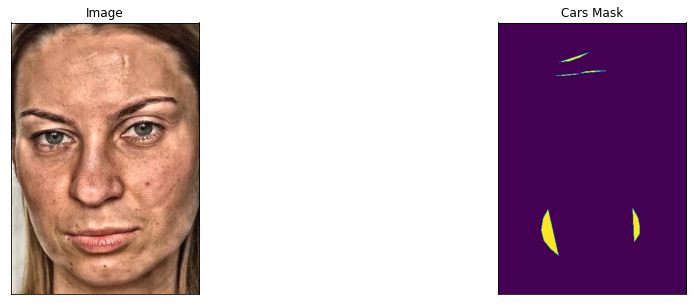

In [ ]:
dataset = Dataset(x_train_dir, y_train_dir, classes = ['acnee', 'wrinkles'])

image, mask = dataset[6] # get some sample
visualize(
    class_num=1,
    image=image, 
    cars_mask=mask
    #sky_mask=mask[..., 1].squeeze(),
    # background_mask=mask[..., 2].squeeze(),
)

In [ ]:
import albumentations as albu

In [ ]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        albu.Resize(256,256, p=1),
        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),
        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),
        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        albu.Lambda(mask=round_clip_0_1)
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [
        albu.Resize(256,256, p=1)              
    ]
    return albu.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
    ]
    return albu.Compose(_transform)

In [ ]:
import segmentation_models as sm

In [ ]:
BACKBONE = 'vgg16'
BATCH_SIZE = 1
CLASSES = ['acnee', 'wrinkles']
LR = 0.0001
EPOCHS = 70

preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

58892288/58889256 [==============================] - 5s 0us/step


In [ ]:
optim = keras.optimizers.Adam(LR)

dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

model.compile(optim, total_loss, metrics)

In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

[(255, 255, 255), (184, 233, 134)]
[(255, 255, 255), (184, 233, 134)]


In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps= len(valid_dataloader),
)

Epoch 1/70
121/121 [==============================] - 112s 922ms/step - loss: 0.9066 - iou_score: 0.1895 - f1-score: 0.2314 - val_loss: 0.8462 - val_iou_score: 0.2803 - val_f1-score: 0.3043
Epoch 2/70
121/121 [==============================] - 104s 856ms/step - loss: 0.8623 - iou_score: 0.3053 - f1-score: 0.3234 - val_loss: 0.8381 - val_iou_score: 0.4080 - val_f1-score: 0.4149
Epoch 3/70
121/121 [==============================] - 108s 889ms/step - loss: 0.8493 - iou_score: 0.3624 - f1-score: 0.3722 - val_loss: 0.8040 - val_iou_score: 0.3889 - val_f1-score: 0.3943
Epoch 4/70
121/121 [==============================] - 105s 867ms/step - loss: 0.8423 - iou_score: 0.3305 - f1-score: 0.3415 - val_loss: 0.7906 - val_iou_score: 0.3249 - val_f1-score: 0.3316
Epoch 5/70
121/121 [==============================] - 103s 855ms/step - loss: 0.8345 - iou_score: 0.3243 - f1-score: 0.3416 - val_loss: 0.7912 - val_iou_score: 0.3776 - val_f1-score: 0.3838
Epoch 6/70
121/121 [==============================

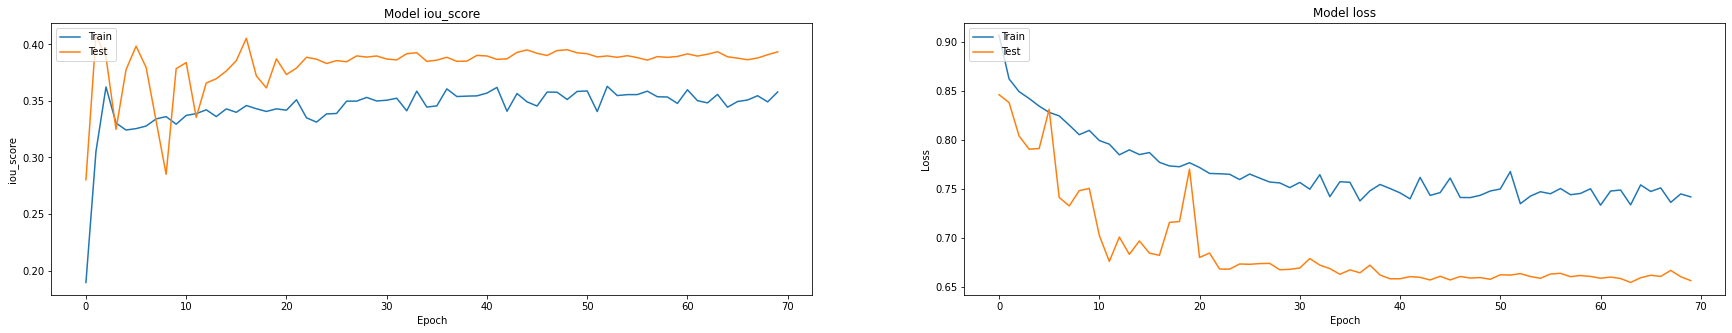

In [ ]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

[(255, 255, 255), (184, 233, 134)]


In [ ]:
# load best weights
model.load_weights('best_model.h5')

In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.70652
mean iou_score: 0.38867
mean f1-score: 0.41878


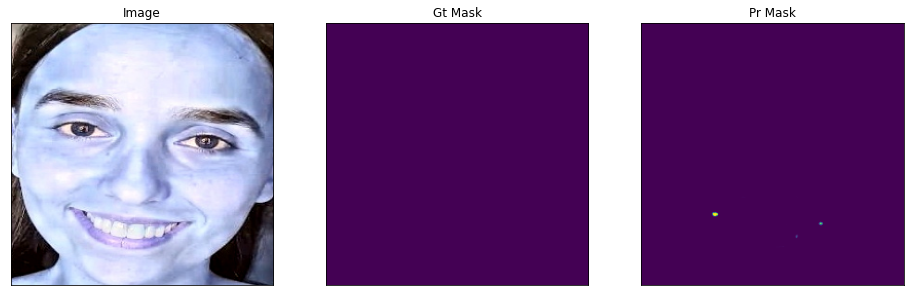

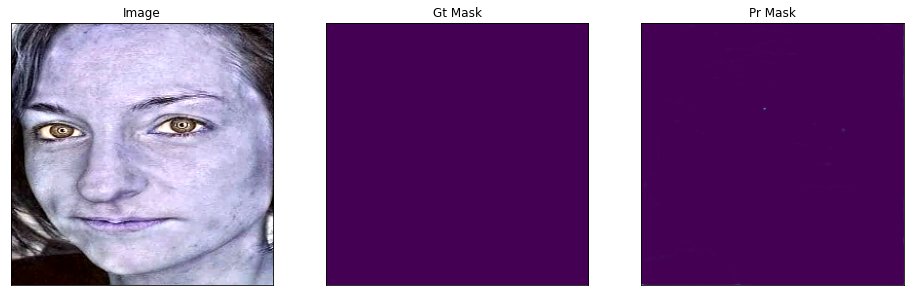

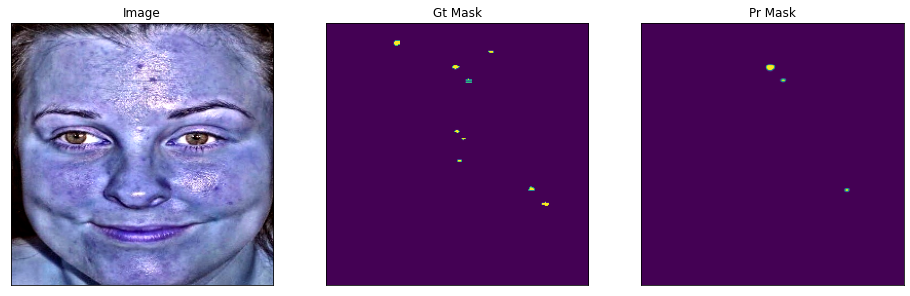

In [ ]:
n = 3
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    visualize(
        class_num=0,
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.squeeze(),
    )